<a href="https://colab.research.google.com/github/soyyoon/ML_project/blob/main/data_generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import random
import time
# 폰트 관련 라이브러리(glob, ImageDraw, ImageFont)는 사용하지 않으므로 제외
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive

drive.mount('/content/drive')

# MNIST 원본 데이터 로드
mnist_data = np.load('/content/drive/MyDrive/ML_Project/mnist_train.npz')
X_train_original = mnist_data['train_images']
y_train_original = mnist_data['train_labels']

# 폰트 경로(FONT_PATHS) 및 폰트 크기(FONT_SIZE) 설정 제거
# 이미지 크기는 MNIST 기본 크기인 28x28로 고정
IMAGE_SIZE = (28, 28)

# 색상 팔레트 및 라벨 인코딩 (유지)
RAINBOW_NAMES = ['RED', 'ORANGE', 'YELLOW', 'GREEN', 'BLUE', 'INDIGO', 'VIOLET']
RAINBOW_COLORS_RGB = [
    (255, 0, 0), (255, 127, 0), (255, 255, 0), (0, 255, 0),
    (0, 0, 255), (75, 0, 130), (148, 0, 211)
]
COLOR_TO_LABEL = {name: i for i, name in enumerate(RAINBOW_NAMES)}
LABEL_TO_COLOR_NAME = {i: name for i, name in enumerate(RAINBOW_NAMES)}

print("\n색상 라벨 인코딩 설정 완료.")
print(COLOR_TO_LABEL)

Mounted at /content/drive

색상 라벨 인코딩 설정 완료.
{'RED': 0, 'ORANGE': 1, 'YELLOW': 2, 'GREEN': 3, 'BLUE': 4, 'INDIGO': 5, 'VIOLET': 6}


### 색상 함수

In [ ]:
# --- 색상 관련 함수 ---
def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 (RGB, 이름) 튜플을 반환합니다."""
    idx = np.random.randint(0, len(RAINBOW_COLORS_RGB))
    return RAINBOW_COLORS_RGB[idx], RAINBOW_NAMES[idx]

def colorize_digit_with_threshold(digit_image_pil, fg_color, bg_color):
    """PIL 이미지에 경계선 번짐 없이 선명한 전경/배경 색을 적용합니다."""
    # 그레이스케일 이미지로 변환하여 마스크 생성 (임계값 128 기준)
    mask = digit_image_pil.convert('L').point(lambda p: 255 if p > 128 else 0)

    # 배경색으로 채워진 새 RGB 이미지 생성
    final_image = Image.new("RGB", digit_image_pil.size, bg_color)

    # 마스크를 이용해 전경색 붙여넣기 (숫자 부분만 전경색으로 칠함)
    final_image.paste(fg_color, mask=mask)
    return final_image

# --- 이미지 소스 관련 (순정 MNIST) ---

# 원본 MNIST 이미지를 숫자별로 미리 분류하여 딕셔너리에 저장 (효율성 증대)
mnist_images_by_label = {i: [] for i in range(10)}
for img, lbl in zip(X_train_original, y_train_original):
    mnist_images_by_label[lbl].append(img)

def get_mnist_image_for_digit(digit):
    """특정 숫자에 해당하는 원본 MNIST 이미지를 랜덤하게 PIL 이미지로 반환합니다."""
    images_list = mnist_images_by_label[digit]
    random_image_np = random.choice(images_list)
    return Image.fromarray(random_image_np.astype('uint8')) # 'L': 8-bit grayscale

# (삭제됨) generate_digit_image_from_font 함수는 폰트 미사용 실험에서 불필요하므로 제거했습니다.

### 데이터 생성 함수 (순정)

In [ ]:
def create_pure_mnist_dataset(num_samples):
    """
    폰트 증강 없이, 오직 원본 MNIST 이미지만 사용하여 컬러 데이터셋을 생성합니다.
    - num_samples: 생성할 샘플의 총 개수
    """
    X_data, y_data_digit, y_data_fg, y_data_bg = [], [], [], []

    print(f"\n[순정 모드] 총 {num_samples}개의 데이터 생성을 시작합니다 (Only Original MNIST)")
    start_time = time.time()

    for _ in tqdm(range(num_samples)):
        # 1. 라벨 생성 (숫자, 전경색, 배경색)
        digit_label = random.randint(0, 9)

        fg_color_rgb, fg_name = get_random_rainbow_color()
        bg_color_rgb, bg_name = get_random_rainbow_color()

        # 전경색과 배경색이 같지 않도록 설정
        while fg_color_rgb == bg_color_rgb:
            bg_color_rgb, bg_name = get_random_rainbow_color()

        fg_label = COLOR_TO_LABEL[fg_name]
        bg_label = COLOR_TO_LABEL[bg_name]

        # 2. 베이스 이미지 생성 (★수정된 부분: 폰트 로직 제거)
        # 무조건 원본 MNIST 이미지 풀에서 가져옵니다.
        base_image_pil = get_mnist_image_for_digit(digit_label)

        # 3. 이미지 색칠하기 (기존 로직 유지)
        colorized_image_pil = colorize_digit_with_threshold(base_image_pil, fg_color_rgb, bg_color_rgb)

        # 4. 전처리 및 저장 (0.0 ~ 1.0 정규화)
        image_np_normalized = np.array(colorized_image_pil) / 255.0

        X_data.append(image_np_normalized)
        y_data_digit.append(digit_label)
        y_data_fg.append(fg_label)
        y_data_bg.append(bg_label)

    end_time = time.time()
    print(f"데이터 생성 완료! (소요 시간: {end_time - start_time:.2f}초)")

    # 최종 Numpy 배열로 변환
    return (np.array(X_data, dtype=np.float32),
            np.array(y_data_digit, dtype=np.int32),
            np.array(y_data_fg, dtype=np.int32),
            np.array(y_data_bg, dtype=np.int32))



### 데이터 생성

In [ ]:
# --- 데이터 생성 실행 (개수는 기존과 동일하게 유지) ---

# 학습 데이터 60,000개 생성 (순정 MNIST 100%)
X_train_gen, y_train_digit, y_train_fg, y_train_bg = create_pure_mnist_dataset(num_samples=60000)

# 검증 데이터 10,000개 생성 (순정 MNIST 100%)
X_val_gen, y_val_digit, y_val_fg, y_val_bg = create_pure_mnist_dataset(num_samples=10000)

print("\n--- [순정] 생성된 데이터셋 Shape ---")
print(f"Train X: {X_train_gen.shape}, Train y_digit: {y_train_digit.shape}")
print(f"Val X: {X_val_gen.shape},  val y_digit: {y_val_digit.shape}")

# --- 저장 경로 설정 및 저장 (파일 이름 변경 권장) ---
SAVE_PATH_TRAIN = '/content/drive/MyDrive/ML_Project/colored_mnist_train_raw.npz'
SAVE_PATH_VAL = '/content/drive/MyDrive/ML_Project/colored_mnist_val_raw.npz'

print("\n[순정] 데이터셋을 NPZ 파일로 저장합니다...")
np.savez_compressed(
    SAVE_PATH_TRAIN,
    images=X_train_gen,
    labels_digit=y_train_digit,
    labels_fg=y_train_fg,
    labels_bg=y_train_bg
)
np.savez_compressed(
    SAVE_PATH_VAL,
    images=X_val_gen,
    labels_digit=y_val_digit,
    labels_fg=y_val_fg,
    labels_bg=y_val_bg
)
print(f"저장 완료:\n -> {SAVE_PATH_TRAIN}\n -> {SAVE_PATH_VAL}")


[순정 모드] 총 60000개의 데이터 생성을 시작합니다 (Only Original MNIST)


  0%|          | 0/60000 [00:00<?, ?it/s]

데이터 생성 완료! (소요 시간: 12.61초)

[순정 모드] 총 10000개의 데이터 생성을 시작합니다 (Only Original MNIST)


  0%|          | 0/10000 [00:00<?, ?it/s]

데이터 생성 완료! (소요 시간: 1.58초)

--- [순정] 생성된 데이터셋 Shape ---
Train X: (60000, 28, 28, 3), Train y_digit: (60000,)
Val X: (10000, 28, 28, 3),  val y_digit: (10000,)

[순정] 데이터셋을 NPZ 파일로 저장합니다...
저장 완료:
 -> /content/drive/MyDrive/ML_Project/colored_mnist_train_raw.npz
 -> /content/drive/MyDrive/ML_Project/colored_mnist_val_raw.npz


### 데이터 생성 검증

검증 데이터 로드 중: /content/drive/MyDrive/ML_Project/colored_mnist_train_raw.npz


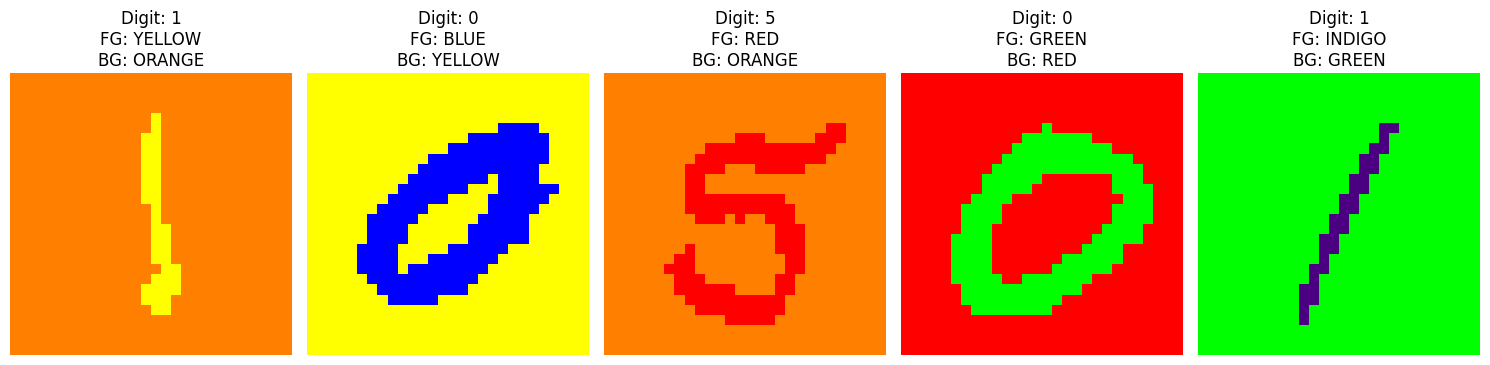

In [ ]:
import matplotlib.pyplot as plt
import random

# [중요] 이전 셀에서 저장한 '순정' 데이터 경로가 SAVE_PATH_TRAIN 변수에 들어있어야 합니다.
# 만약 변수가 끊겼다면 아래 주석을 해제하고 경로를 직접 지정하세요.
# SAVE_PATH_TRAIN = '/content/drive/MyDrive/ML_Project/colored_mnist_train_raw.npz'

print(f"검증 데이터 로드 중: {SAVE_PATH_TRAIN}")

# 저장된 학습 데이터 불러오기
verify_data = np.load(SAVE_PATH_TRAIN)
X_verify = verify_data['images']
y_digit_verify = verify_data['labels_digit']
y_fg_verify = verify_data['labels_fg']
y_bg_verify = verify_data['labels_bg']

# 5개의 랜덤 샘플 시각화
plt.figure(figsize=(15, 4))
for i in range(5):
    idx = random.randint(0, len(X_verify) - 1)

    plt.subplot(1, 5, i + 1)
    # 이미지 출력 (H, W, C)
    plt.imshow(X_verify[idx])

    digit = y_digit_verify[idx]
    # LABEL_TO_COLOR_NAME 딕셔너리는 맨 처음 설정 코드에 정의되어 있어야 합니다.
    fg_color_name = LABEL_TO_COLOR_NAME[y_fg_verify[idx]]
    bg_color_name = LABEL_TO_COLOR_NAME[y_bg_verify[idx]]

    plt.title(f"Digit: {digit}\nFG: {fg_color_name}\nBG: {bg_color_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()